<a href="https://colab.research.google.com/github/katirasole/multi-label-text-classification/blob/main/Multi_Label_Text_Classification_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification with Keras
By Katira Soleymanzadeh 

In this notebook, Bidirectional-LSTM model is utilized for multi-label text classification task. To accomplish this task, Keras library is used.

#Install requirements and Import libraries

Install required packages first and then import necessary libraries. 

Python version 3.6.9

Tensorflow version 2.3.0

Keras version 2.4.0

In [1]:
!pip3 install tensorflow==2.3

In [2]:
!pip3 install keras==2.4.0

     |████████████████████████████████| 174kB 7.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [22]:
#import required libraries
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K

import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns

#for text pre-processing 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

#for evaluation
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Download Dataset

Clone the github repository and mount the google drive to access the data. 


In [4]:
if not os.path.exists('./multi_label_text_classification'):
    print("---Cloning the repo start---")
    !git clone https://github.com/katirasole/multi-label-text-classification.git
else:
    print("---The repo is already exist---")

---Cloning the repo start---
Cloning into 'multi-label-text-classification'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
!ls multi-label-text-classification/data

test.csv  test_labels.csv  train.csv


In [12]:
# ----------Data-------------    
data_dir = "./multi-label-text-classification/data/"

train_file = (data_dir + 'train.csv')
test_file = (data_dir + 'test.csv')
test_labels_file = (data_dir + 'test_labels.csv')

print("---Read data---")
#-----------------train file-------------------------
train = pd.read_csv(train_file)

#-----------------test file-------------------------
test_raw = pd.read_csv(test_file)

#------------------test labels-----------------
test_labels = pd.read_csv(test_labels_file)

print("---Complete reading data---")

---Read data---
---Complete reading data---


In [13]:
#Merge the test commeent text with its lables in one dataframe
test = pd.merge(test_raw, test_labels, on='id', how='inner')

# Dataset Statistics


In [14]:
print("Number of rows in TRAIN data =", train.shape[0])
print("Number of columns in TRAIN data =", train.shape[1])
print("\n")
print("-------------------------TRAIN data:-------------------------")
train.head()

Number of rows in TRAIN data = 159571
Number of columns in TRAIN data = 8


-------------------------TRAIN data:-------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
print("Number of rows in TEST data =", test.shape[0])
print("Number of columns in TEST data =", test.shape[1])
print("\n")
print("-------------------------TEST data:-------------------------")
test.head()

Number of rows in TEST data = 153164
Number of columns in TEST data = 8


-------------------------TEST data:-------------------------


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [16]:
#The number of comments for each class

classes = list(train.columns.values)
classes = classes[2:]
print("Classes:\n\n", classes)

numbers = []
for i in classes:
    numbers.append((i, train[i].sum()))
df_statistics = pd.DataFrame(numbers, columns=['Class', 'Number of Comments'])

df_statistics

Classes:

 ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,Class,Number of Comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


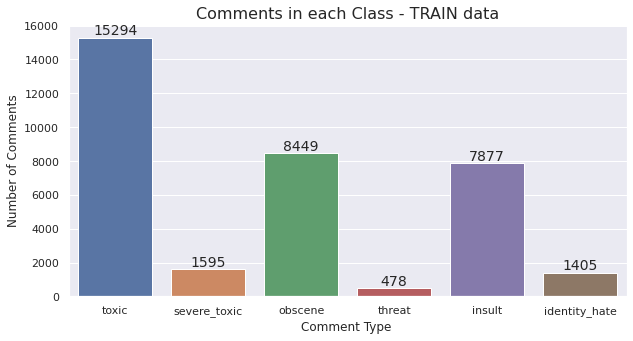

In [17]:
sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax= sns.barplot(classes, train.iloc[:,2:].sum().values)

plt.title("Comments in each Class - TRAIN data", fontsize=16)
plt.ylabel('Number of Comments', fontsize=12)
plt.xlabel('Comment Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=14)

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


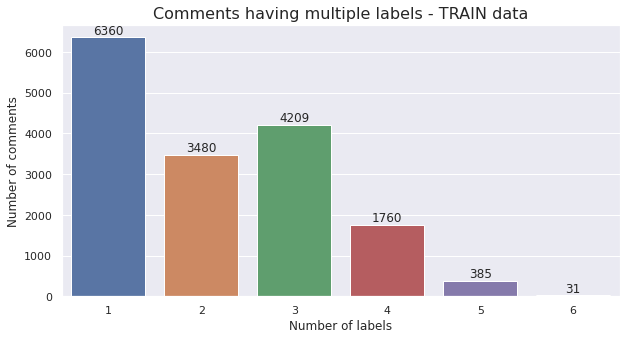

In [18]:
rowSums = train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.sort_index()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels - TRAIN data", fontsize=16)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


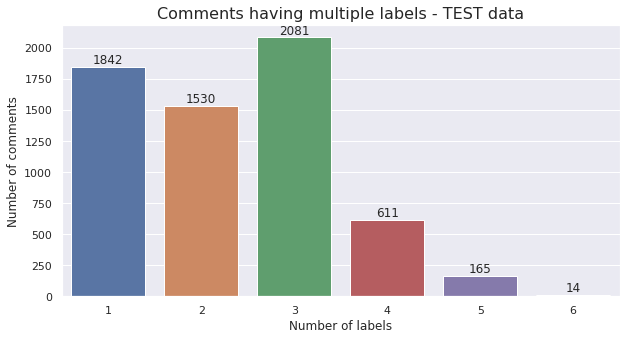

In [19]:
rowSums = test.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.sort_index()
multiLabel_counts = multiLabel_counts.iloc[2:]

sns.set(font_scale = 1)
plt.figure(figsize=(10,5))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels - TEST data", fontsize=16)
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Number of labels', fontsize=12)

#adding the text labels
rects = ax.patches
labels = (multiLabel_counts.values)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

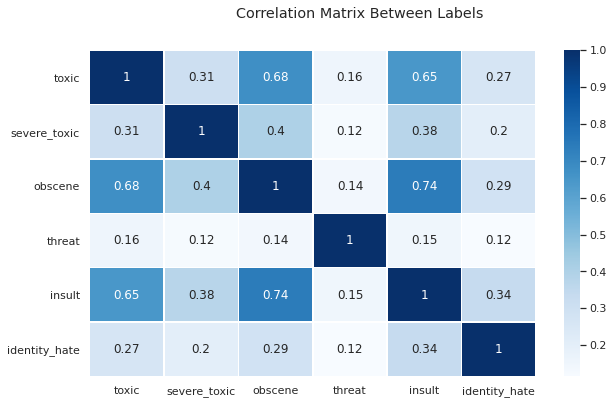

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix Between Labels')
sns.heatmap(train.corr(), annot=True, cmap="Blues", linewidths=.5, ax=ax);

## Pre-Processing Data

To pre-process the data the following steps are done:

*   Remove the html tags 
*   Remove punctuation

*   Check if the word is made up of English letters and is not alphanumeric
*   Do lowercase

*   Remove Stopwords
*   Stemming (Snowball or Porter Stemming)

In [23]:
#Remove the html tags
def cleanHtml(text):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(text))
    return cleantext

#Remove punctuation or special characters
def cleanPunc(text): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',text)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

#Check if the word is made up of English letters and is not alphanumeric
def keepAlpha(text):
    alpha_sent = ""
    for word in text.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

#Remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

#Do stemming (Snowball or Porter Stemming)
stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

Pre-process Train set

In [24]:
train['comment_text'] = train['comment_text'].str.lower()
train['comment_text'] = train['comment_text'].apply(cleanHtml)
train['comment_text'] = train['comment_text'].apply(cleanPunc)
train['comment_text'] = train['comment_text'].apply(keepAlpha)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on impr...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [25]:
train['comment_text'] = train['comment_text'].apply(removeStopWords)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore m...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy c...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement won...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page on,0,0,0,0,0,0


In [26]:
train['comment_text'] = train['comment_text'].apply(stemming)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explan edit made usernam hardcor metallica fan...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww match background colour seem stuck thank t...,0,0,0,0,0,0
2,000113f07ec002fd,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chanc rememb page on,0,0,0,0,0,0


Pre-process Test set

In [27]:
test['comment_text'] = test['comment_text'].str.lower()
test['comment_text'] = test['comment_text'].apply(cleanHtml)
test['comment_text'] = test['comment_text'].apply(cleanPunc)
test['comment_text'] = test['comment_text'].apply(keepAlpha)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule is more succesful then you ll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,from rfc the title is fine as it is imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sources zawe ashton on lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,if you have a look back at the source the info...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,i don t anonymously edit articles at all,-1,-1,-1,-1,-1,-1


In [28]:
test['comment_text'] = test['comment_text'].apply(removeStopWords)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succesful ever whats ...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,rfc title fine imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sources zawe ashton lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,look back source information updated ...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,anonymously edit articles all,-1,-1,-1,-1,-1,-1


In [29]:
test['comment_text'] = test['comment_text'].apply(stemming)
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,yo bitch ja rule succes ever what hate sad mof...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,rfc titl fine imo,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,sourc zaw ashton lapland,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,look back sourc inform updat correct form gues...,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,anonym edit articl all,-1,-1,-1,-1,-1,-1


# Dataset Vectorization

In [30]:
num_words = 20000      #Max. words to use for each comment
max_features = 200000  #Max. number of unique words in embeddinbg vector
max_len = 200          #Max. number of words per toxic comment to be use
embedding_dims = 128   #embedding vector dimension 
num_epochs = 5        
batch_size = 256    

In [150]:
#Convert text to vectors using keras pre-processing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

#Tokenization    
tokenizer = Tokenizer(num_words, oov_token=True)
#tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
#Padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (153164, 200)


If you want to use pre-trained word embeddings (GloVe), use the following code

In [ ]:
"""GLOVE_EMBEDDING = "embedding/glove.6B.100d.txt"

embeddings_index = {}

with open(GLOVE_EMBEDDING, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        embed = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embed

word_index = tokenizer.word_index

num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embed_size), dtype='float32')

for word, i in word_index.items():

    if i >= max_words:
        continue

    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector"""

# Evaluation metrics

TP: true positive, FP: false positive, TN: true negative, FN: false negative

*   Precision (TP / (TP + FP) ) measures the ability of a classifier to identify only the correct instances for each class.
*   Recall (TP / (TP + FN) is the ability of a classifier to find all correct instances per class.

*   F1 score is a weighted harmonic mean of precision and recall normalized between 0 and 1.

*   Accuracy (TP+TN)/(TP+TN+FP+FN) is a fraction of correctly classified
instances to the total number of instances to be classified.



In [156]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


#Classification Model

Use Bi-LSTM to classify the samples 

In [157]:
model = Sequential([
                    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
                    SpatialDropout1D(0.5),
                    Bidirectional(LSTM(25, return_sequences=True)),
                    BatchNormalization(),
                    Dropout(0.5),
                    GlobalMaxPool1D(),
                    Dense(50, activation = 'relu'),
                    Dense(6, activation = 'sigmoid')
                    ])

In [158]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)
model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall])

In [159]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_6 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_6 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)               

#Store the model

In [160]:
#store model ------ 
# run this in training mode
checkpoint_path = "./multi-label-text-classification/store_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='./logs'),
            cp_callback]

model_fit = model.fit(X_train, 
                      y_train, 
                      validation_split=0.1, 
                      batch_size=batch_size,
                      epochs=num_epochs, 
                      callbacks=callbacks)

Epoch 1/5
561/561 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9588 - precision: 0.7655 - recall: 0.5818
Epoch 00001: saving model to ./multi-label-text-classification/store_model/cp.ckpt
561/561 [==============================] - 362s 646ms/step - loss: 0.0621 - accuracy: 0.9588 - precision: 0.7655 - recall: 0.5818 - val_loss: 0.0659 - val_accuracy: 0.9868 - val_precision: 0.8589 - val_recall: 0.5933
Epoch 2/5
561/561 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9875 - precision: 0.8160 - recall: 0.6778
Epoch 00002: saving model to ./multi-label-text-classification/store_model/cp.ckpt
561/561 [==============================] - 363s 647ms/step - loss: 0.0453 - accuracy: 0.9875 - precision: 0.8160 - recall: 0.6778 - val_loss: 0.0710 - val_accuracy: 0.9922 - val_precision: 0.7223 - val_recall: 0.7498
Epoch 3/5
561/561 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9904 - precision: 0.8229 - recall: 0.7081
Epoc

# Evaluate the model on Train and Test set

In [179]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [162]:
train_score = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1)
print('Train Loss:', train_score[0])
print('Train Accuracy:', train_score[1])

624/624 [==============================] - 95s 152ms/step - loss: 0.0407 - accuracy: 0.9940 - precision: 0.8699 - recall: 0.7446
Train Loss: 0.04068460687994957
Train Accuracy: 0.9940277338027954


In [163]:
test_score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

599/599 [==============================] - 89s 149ms/step - loss: -2.8457 - accuracy: 0.9986 - precision: 0.1513 - recall: 0.6979
Test Loss: -2.8457000255584717
Test Accuracy: 0.9985636472702026


# Predict labels of unseen example


In [190]:
text = input("Give your example: \n")
#text = ""That's helpful. MOS be damned, Thecodingproject thinks it's '10x' worse. —""
#gold-labels = [1,0,1,0,1,0]

Give your example: 
"That's helpful. MOS be damned, Thecodingproject thinks it's '10x' worse. —"


In [191]:
def predict_unseen(sent):
    sent = sent.lower()
    sent = cleanHtml(sent)
    sent = cleanPunc(sent)
    sent = keepAlpha(sent)
    sent = removeStopWords(sent)
    sent = stemming(sent)
    print ("Pre-Processed Text ----> \n", sent)
    tokenizer.fit_on_texts(list(sent.split()))
    X = tokenizer.texts_to_sequences(sent.split())
    predictions = model.predict(np.expand_dims(X, 0))
    return predictions

predicted = predict_unseen(text)
print ("Predicted Labels --->  \n", predicted[0])

Pre-Processed Text ----> 
 help mos damn thecodingproject think x wors
Predicted Labels --->  
 [0.6454665  0.23653609 0.35564816 0.28805697 0.30192092 0.20040578]
